In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 开始使用：使用自定义容器在NVIDIA Triton推理服务器上合并多个模型

<table align="left">
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/vertex_endpoints/nvidia-triton/get_started_with_triton_ensemble.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      在GitHub上查看
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/vertex_endpoints/nvidia-triton/get_started_with_triton_ensemble.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      在Vertex AI Workbench中打开
    </a>
  </td>  
</table>

## 概述

本教程展示了如何使用运行[NVIDIA Triton推理服务器（Triton）](https://developer.nvidia.com/nvidia-triton-inference-server)的自定义容器，在[Vertex AI预测](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions)上部署包括合并模型在内的多个模型，用于提供在线预测。

了解更多关于[Vertex AI预测](https://cloud.google.com/vertex-ai/docs/predictions/get-predictions)的信息。


### 目标

在本教程中，您将部署一个运行Nvidia Triton服务器的自定义容器，用于提供来自合并模型的预测，然后使用Vertex AI端点来检测图像中的对象。

本教程中执行的步骤包括：

- 为多个预建模型创建Triton配置文件
- 获取运行Triton的自定义Serving容器
- 将Triton多模型包上传为Vertex `Model`资源
- 将`Model`资源部署到服务`Endpoint`资源。
- 作为单独模型进行预测请求。
- 作为模型集成进行预测请求。
- 取消部署`Model`资源并删除`Endpoint`。

### 数据集

本笔记本使用随机数据生成器来训练和提供模型。

### 成本

本教程使用Google Cloud的可计费组件：

* Vertex AI
* 云存储

了解[Vertex AI定价](https://cloud.google.com/vertex-ai/pricing)和[云存储定价](https://cloud.google.com/storage/pricing)，并使用[定价计算器](https://cloud.google.com/products/calculator/)根据您的预计使用情况生成成本估算。

## NVIDIA Triton推理服务器（Triton）概述

[NVIDIA Triton推理服务器（Triton）](https://github.com/triton-inference-server/server)提供了一种优化为CPU和GPU的推理解决方案。Triton可以在单个GPU或CPU上同时运行来自相同或不同框架的多个模型。在多GPU服务器中，它会自动在每个GPU上为每个模型创建一个实例，以增加利用率而无需额外编码。它支持实时推理，批量推理以最大化GPU/CPU利用率，并支持具有内置音频流输入支持的流式推理。它还支持用于需要多个模型执行端到端推理的用例的模型集成。

以下图显示了Triton的高级架构。

![Triton高级架构](https://raw.githubusercontent.com/triton-inference-server/server/main/docs/user_guide/images/arch.jpg)

- 模型存储库是一个基于文件系统的存储库，其中包含Triton将用于推理的模型。
- 推理请求通过HTTP/REST或gRPC到达服务器，然后被路由到适当的每个模型调度程序。
- Triton实现了可以在逐个模型基础上配置的多种调度和批处理算法。
- 后端使用批量请求中提供的输入执行推理，以生成所请求的输出。

Triton提供准备就绪和活动状态的健康端点，以及利用率、吞吐量和延迟指标，这使得Triton能够集成到部署环境中，例如Vertex AI Prediction。

有关更详细信息，请参阅[Triton架构](https://github.com/triton-inference-server/server/blob/main/docs/architecture.md)。

## Triton在Vertex AI Prediction上的应用

Triton推理服务器在由NVIDIA GPU云（NGC）发布的容器内运行 - [NVIDIA Triton推理服务器镜像](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver)。NVIDIA和GCP Vertex AI团队合作添加了包和配置，以满足Triton与Vertex AI [自定义Serving容器图像的要求](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements)。

要由Triton提供服务的模型应该在Vertex AI中注册为 `Model` 资源。 `Model` 的元数据引用了云存储中模型集成工件的位置以及包括配置的自定义Serving容器。

Triton载入模型并通过[标准推理协议](https://github.com/kserve/kserve/tree/master/docs/predict-api/v2)公开推理、健康和模型管理REST端点。在部署到Vertex AI时，Triton会识别Vertex AI环境，并采用Vertex AI Prediction协议进行[健康检查](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements#health)和预测。

要通过Vertex AI Endpoint调用模型，请使用[标准推理请求JSON对象](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md#inference)或[具有二进制扩展的推理请求JSON对象](https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_binary_data.md)格式化预测请求，并提交请求到Vertex AI Prediction的[REST rawPredict端点](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/projects.locations.endpoints/rawPredict)。因为Triton使用的推理请求格式与Vertex AI Prediction [标准输入格式](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models#formatting-prediction-input)不兼容，所以您需要使用`rawPredict`而不是`predict`方法。

![triton-on-vertex-ai-predictions](https://cloud.google.com/vertex-ai/docs/predictions/images/using-triton-on-vertex-ai-predictions-architecture.png)

设置本地开发环境

此笔记本仅支持[Vertex AI Workbench](https://cloud.google.com/vertex-ai/docs/workbench/introduction)，Vertex AI Workbench环境已满足运行此笔记本的所有要求。请确保您在Vertex AI Workbench笔记本环境中以TensorFlow内核运行笔记本。

**注意：** 在部署自定义容器到Vertex AI Predictions之前，此笔记本使用`docker`命令在本地开发环境中构建和测试容器。 [Google Colab目前不支持原生运行docker](https://github.com/googlecolab/colabtools/issues/299#issuecomment-615308778)，因此该笔记本仅在Vertex AI Workbench上受支持。

## 安装

安装以下包，以便执行此笔记本。

In [ ]:
# Install the packages
! pip3 install --user --upgrade google-cloud-aiplatform

! pip3 install tritonclient geventhttpclient transformers

## 开始之前

### GPU运行时

本教程不需要GPU运行时。

### 设置你的Google Cloud项目

**无论你使用什么笔记本环境，以下步骤都是必须的。**

1. [选择或创建一个Google Cloud项目](https://console.cloud.google.com/cloud-resource-manager)。当你第一次创建一个帐户时，你将获得$300的免费信用额用于计算/存储成本。

2. [确保为你的项目启用计费。](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [启用以下API：Vertex AI APIs，Compute Engine APIs和Cloud Storage。](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component,storage-component.googleapis.com)

4. [Google Cloud SDK](https://cloud.google.com/sdk)已经安装在Google Cloud Notebook中。

5. 在下面的单元格中输入你的项目ID。然后运行该单元格以确保
Cloud SDK在这个笔记本中的所有命令中使用正确的项目。

**注意**：Jupyter会将以`!`为前缀的行作为shell命令运行，并且会插入以`$`为前缀的Python变量。

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### 区域

您还可以更改`REGION`变量，该变量用于整个笔记本的操作。 以下是Vertex AI支持的区域。 我们建议您选择离您最近的区域。

- 美洲：`us-central1`
- 欧洲：`europe-west4`
- 亚太：`asia-east1`

您可能不会使用多区域存储桶来训练Vertex AI。 并非所有区域都支持所有Vertex AI服务。

了解有关[Vertex AI区域](https://cloud.google.com/vertex-ai/docs/general/locations)的更多信息.

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

验证您的Google Cloud账号

**如果您正在从Vertex AI Workbench运行Notebook，则您的环境已经经过了身份验证。**

### 创建一个云存储桶

**无论你使用什么笔记本环境，以下步骤都是必须的。**

当你初始化用于 Python 的 Vertex SDK 时，你需要指定一个云存储暂存桶。这个暂存桶是你的数据集和模型资源相关数据在会话间保留的地方。

在下面设置你的云存储桶的名称。桶名称必须在所有谷歌云项目中是全局唯一的，包括你的组织之外的项目。

In [ ]:
BUCKET_URI = "gs://your-bucket-name-unique"  # @param {type:"string"}

**只有当您的存储桶还不存在时**：才运行以下单元格以创建您的云存储存储桶。

In [ ]:
! gsutil mb -l $REGION $BUCKET_URI

最后，通过检查其内容来验证对云存储桶的访问权限。

In [ ]:
! gsutil ls -al $BUCKET_URI

### 设置变量

接下来，设置一些在教程中使用的变量。
### 导入库

In [ ]:
import json
import os

import numpy as np
import tritonclient.http as triton_http
from google.api import httpbody_pb2
from google.cloud import aiplatform as aip
from google.cloud import aiplatform_v1 as gapic

### 定义常量

`MODEL_ARTIFACTS_REPOSITORY` - Triton 模型存储的云存储位置。

In [ ]:
MODEL_ARTIFACTS_REPOSITORY = (
    "gs://cloud-samples-data/vertex-ai/model-deployment/models/triton_models"
)

以下一组常量将被用来创建Vertex AI Prediction资源的名称和显示名称，如模型、端点和模型部署。

In [ ]:
# set model names and version
MODEL_NAME = "ensemble"
MODEL_VERSION = "v01"
MODEL_DISPLAY_NAME = f"triton-{MODEL_NAME}-{MODEL_VERSION}"
ENDPOINT_DISPLAY_NAME = f"endpoint-{MODEL_NAME}-{MODEL_VERSION}"

# You can get the latest Triton image uri from
# https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver
NGC_TRITON_IMAGE_URI = "nvcr.io/nvidia/tritonserver:22.05-py3"

# prediction container image name
IMAGE_NAME = "vertex-triton-inference:22.05"

### 为Python初始化Vertex AI SDK

为您的项目和对应的存储桶初始化Python的Vertex AI SDK。

In [ ]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

准备模型构件

`config.pbtxt` 文件描述了集成模型的[模型配置](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md)。例如：

> ```
> └── model-repository-path
>        └── model_name
>               ├── config.pbtxt
>               └── 1
>                   └── model.savedmodel
>                         └── <saved-model-files>
> ```

请提供文本以便翻译。
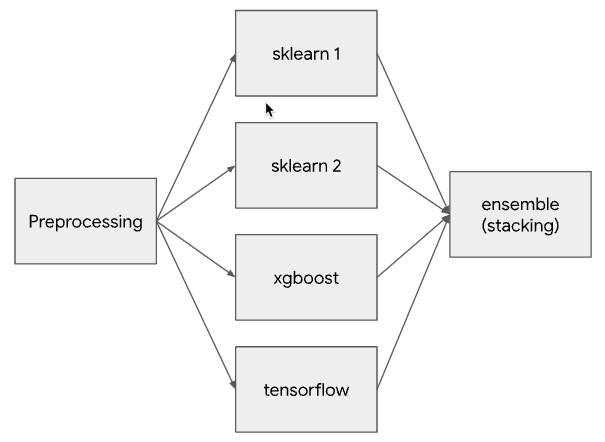

### 集成学习的预建模型

接下来，查看您在此模型集成中使用的预建模型。

In [ ]:
! gsutil ls -R {MODEL_ARTIFACTS_REPOSITORY}

### 创建模型配置文件

[model configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) 文件 `config.pbtxt` 提供关于模型的输入和输出等信息。请参考 [Triton docs](https://github.com/triton-inference-server/common/blob/main/protobuf/model_config.proto) 了解配置格式。对于 TensorFlow 模型，可以使用 [`saved_model_cli` 命令](https://www.tensorflow.org/guide/saved_model#details_of_the_savedmodel_command_line_interface) 并映射到 Triton 的配置格式。请注意 Triton 的数据类型与框架不同，应根据[这里](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md#datatypes)的表格进行相应映射。

In [ ]:
! gsutil cat {MODEL_ARTIFACTS_REPOSITORY}/ensemble/config.pbtxt

构建并推送容器镜像

要使用自定义容器来提供预测服务，您需要指定一个符合[自定义容器要求](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements)的Docker容器镜像。本节介绍如何创建运行 Triton 的容器镜像并将其推送到 Artifact Registry。

### 设置Artifact注册表

为您的项目启用Artifact Registry API服务。

In [ ]:
! gcloud services enable artifactregistry.googleapis.com

创建一个私有的Docker仓库来推送容器镜像。

In [ ]:
DOCKER_ARTIFACT_REPO = "triton-prediction-container"

In [ ]:
# create a new Docker repository with your region with the description
! gcloud artifacts repositories create {DOCKER_ARTIFACT_REPO} \
    --repository-format=docker \
    --location={REGION} \
    --description="Triton Docker repository"

# verify that your repository was created.
! gcloud artifacts repositories list \
    --location={REGION} \
    --filter="name~"{DOCKER_ARTIFACT_REPO}

在推送或拉取容器映像之前，配置Docker来使用`gcloud`命令行工具对您所在地区的Artifact Registry进行身份验证。

In [ ]:
! gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet

构建该镜像并标记镜像将被推送到的存储库路径。

In [ ]:
IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{DOCKER_ARTIFACT_REPO}/{IMAGE_NAME}"

In [ ]:
%%bash -s $NGC_TRITON_IMAGE_URI

export NGC_TRITON_IMAGE_URI=$1

cat <<EOF > Dockerfile

FROM $NGC_TRITON_IMAGE_URI AS triton

RUN pip3 install transformers

EOF

In [ ]:
! docker build -t $IMAGE_URI .

在将自定义容器映像推送到 Artifact Registry 以在 Vertex AI 预测中使用之前，可以选择在本地运行容器来验证服务器对预测实例的响应。

#### 开始运行容器映像

要在本地作为容器运行容器映像，请运行以下命令：

In [ ]:
! docker stop ensemble 2>/dev/stderr
! docker run -t -d -p 8000:8000 --rm \
    --name=ensemble \
    -e AIP_MODE=True \
    --shm-size=256m \
    --gpus all \
    $IMAGE_URI \
    --model-repository $MODEL_ARTIFACTS_REPOSITORY
! sleep 20

In [ ]:
# check if the triton container is running locally
!docker container ls -f"name=ensemble" --no-trunc

执行健康检查

要向容器的服务器发送健康检查，请运行以下命令。它应该返回状态代码为`200`。

In [ ]:
! curl -s -o /dev/null -w "%{http_code}" http://localhost:8000/v2/health/ready

发送预测请求

要向容器的服务器发送预测请求，请运行以下脚本，并使用基于模型类型（scikit-learn、xgboost、tensorflow、ensemble）的样本负载获取预测响应。

In [ ]:
def get_triton_prediction_local(model_name, url="localhost:8000", headers=None):
    # set up both HTTP and GRPC clients. Note that the GRPC client is generally
    # somewhat faster.
    http_client = triton_http.InferenceServerClient(
        url=url, verbose=False, concurrency=5
    )

    # generate example data to classify
    features = 4
    samples = 1
    data = np.random.rand(samples, features).astype("float32")

    # payload configuration defining input and output names
    payload_config = {
        "sci_1": {"input": "input__0", "output": "output__0"},
        "sci_2": {"input": "input__0", "output": "output__0"},
        "xgb": {"input": "input__0", "output": "output__0"},
        "tf": {"input": "dense_input", "output": "round"},
        "ensemble": {"input": "INPUT0", "output": "OUTPUT0"},
    }

    # get input and output names based on model name
    input_name = payload_config[model_name]["input"]
    output_name = payload_config[model_name]["output"]

    # set up Triton input and output objects for HTTP
    triton_input_http = triton_http.InferInput(input_name, (samples, features), "FP32")
    triton_input_http.set_data_from_numpy(data, binary_data=False)
    triton_output_http = triton_http.InferRequestedOutput(
        output_name, binary_data=False
    )

    # submit inference request
    request_http = http_client.infer(
        model_name,
        model_version="1",
        inputs=[triton_input_http],
        outputs=[triton_output_http],
        headers=headers,
    )

    # get results as numpy arrays
    result_http = request_http.as_numpy(output_name)
    print(f"request: {data}")
    print(f"response: {result_http}")

In [ ]:
# model names: sci_1, sci_2, xgb, tf, ensemble
TRITON_URL = "localhost:8000"

for model_name in ["sci_1", "sci_2", "xgb", "tf", "ensemble"]:
    print(f"Predictions from model: {model_name}")
    get_triton_prediction_local(model_name, TRITON_URL)
    print("-" * 16)

停止运行容器

要停止容器，请运行以下命令：

In [ ]:
! docker stop ensemble

### 将容器镜像推送到Artifact Registry

在本地测试完容器镜像后，将镜像推送到Artifact Registry。创建Vertex AI模型资源时，将使用Artifact Registry镜像URI。

In [ ]:
! docker push $IMAGE_URI

创建顶点 AI 模型资源

必须创建一个顶点 AI 模型资源才能将模型部署到顶点 AI 预测终端点。创建一个顶点 AI 模型资源，部署图像指向模型构件。请参考[顶点 AI 预测指南](https://cloud.google.com/vertex-ai/docs/predictions/use-custom-container)了解如何使用自定义容器创建顶点 AI 模型资源。

In [ ]:
print(f"MODEL_ARTIFACTS_REPOSITORY = {MODEL_ARTIFACTS_REPOSITORY}")
print(f"MODEL_DISPLAY_NAME = {MODEL_DISPLAY_NAME}")
print(f"IMAGE_URI = {IMAGE_URI}")

In [ ]:
model = aip.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    serving_container_image_uri=IMAGE_URI,
    artifact_uri=MODEL_ARTIFACTS_REPOSITORY,
    sync=True,
    serving_container_args=[
        "--backend-config=tensorflow,version=2",
        "--backend-config=tensorflow,transfer_threshold=0",
        "--backend-config=python,shm-default-byte-size=33554432,shm-growth-byte-size=8388608",
        "--backend-config=fil,transfer_threshold=0",
        "--vertex-ai-default-model=ensemble",
        "--strict-model-config=true",
        "--log-verbose=99",
        "--log-error=1",
    ],
)

print(model.resource_name)

## 将模型部署到Vertex AI预测

部署Vertex AI模型是一个两步过程。

1. 创建一个`Endpoint`，向使用模型的用户暴露外部接口。
2. 在`Endpoint`准备就绪后，将多个版本的模型部署到`Endpoint`。部署的模型运行自定义容器图像，其中运行Triton以提供预测。

创建终端点

在部署您创建的`模型`之前，您需要创建一个`Vertex AI终端点`。

In [ ]:
endpoint = aip.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)

### 部署模型到端点

在`端点`准备好之后，将`模型`部署到`端点`。部署的模型在配备NVIDIA Tesla T4 GPU的GPU节点上运行Triton Server。

欲了解更多信息，请参阅[使用Vertex AI API部署模型](https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api)指南。

**注意：** 此步骤可能需要长达20分钟。

In [ ]:
traffic_percentage = 100
machine_type = "n1-standard-4"
accelerator_type = "NVIDIA_TESLA_T4"
accelerator_count = 1
min_replica_count = 1
max_replica_count = 2

model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=MODEL_DISPLAY_NAME,
    machine_type=machine_type,
    min_replica_count=min_replica_count,
    max_replica_count=max_replica_count,
    traffic_percentage=traffic_percentage,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
    sync=True,
)

print(endpoint.name)

## 调用模型并获取预测结果

要通过Vertex AI预测端点调用模型，请使用标准推断请求JSON对象或具有二进制扩展的推断请求JSON对象格式化预测请求，并将请求提交给Vertex AI预测的REST rawPredict端点。

---

必须使用`rawPredict` API而不是`predict` API，因为Triton使用的预测请求格式与Vertex AI预测的标准输入格式不兼容。

---

在[上一节](#Download-test-image-file-and-generate-payload-to-make-prediction-requests)中，请求主体被格式化为标准推断请求JSON对象。

您可以使用[Vertex AI SDK](https://googleapis.dev/python/aiplatform/latest/aiplatform_v1/prediction_service.html#:~:text=async-,raw_predict,-(request%3A%20Optional%5BUnion)调用Vertex AI Prediction `rawPredict`终点，也可以使用任何HTTP工具或库，包括`curl`。

在另一个会话中使用`Endpoint`：将终点设置为以下内容

```
endpoint = aip.Endpoint('projects/<project-number>/locations/<region>/endpoints/<endpoint-id>')
```

使用Vertex AI SDK调用`rawPredict`获取预测响应。

以下功能调用部署在Vertex AI端点上的Triton推理服务器，需要提供端点资源名称、在同一端点上部署多个模型时要调用的模型名称以及要传递给Triton推理服务器的附加标头。

In [ ]:
def get_triton_prediction_vertex(
    model_name,
    endpoint_name,
    api_endpoint=f"{REGION}-aiplatform.googleapis.com",
    headers=None,
):
    # set up vertex ai prediction client
    client_options = {"api_endpoint": api_endpoint}
    gapic_client = gapic.PredictionServiceClient(client_options=client_options)

    # generate example data to classify
    features = 4
    samples = 1
    data = np.random.rand(samples, features).astype("float32")

    # payload configuration defining input and output names
    payload_config = {
        "sci_1": {"input": "input__0", "output": "output__0"},
        "sci_2": {"input": "input__0", "output": "output__0"},
        "xgb": {"input": "input__0", "output": "output__0"},
        "tf": {"input": "dense_input", "output": "round"},
        "ensemble": {"input": "INPUT0", "output": "OUTPUT0"},
        "mux": {
            "input": "mux_in",
            "output": ["mux_xgb_out", "mux_tf_out", "mux_sci_1_out", "mux_sci_2_out"],
        },
    }

    # get input and output names based on model name
    input_name = payload_config[model_name]["input"]
    output_name = payload_config[model_name]["output"]

    # set up Triton input and output objects for HTTP
    triton_input_http = triton_http.InferInput(input_name, (samples, features), "FP32")
    triton_input_http.set_data_from_numpy(data, binary_data=False)

    if isinstance(output_name, list):
        triton_output_http = [
            triton_http.InferRequestedOutput(output, binary_data=False)
            for output in output_name
        ]

    else:
        triton_output_http = [
            triton_http.InferRequestedOutput(output_name, binary_data=False)
        ]

    # create inference request
    _data, _ = triton_http._utils._get_inference_request(
        inputs=[triton_input_http],
        outputs=triton_output_http,
        request_id="",
        sequence_id=0,
        sequence_start=False,
        sequence_end=False,
        priority=0,
        timeout=None,
        custom_parameters=None,
    )
    http_body = httpbody_pb2.HttpBody(data=_data, content_type="application/json")
    print(f"request: {data}")
    # submit inference request
    request = gapic.RawPredictRequest(endpoint=endpoint_name, http_body=http_body)
    response = gapic_client.raw_predict(request=request, metadata=headers)
    # get result as json
    result_http = json.loads(response.data.decode("utf-8"))
    print(f"response: {result_http['outputs'][0]['data']}")

#### 发出模型集成预测请求

调用Vertex AI端点，从部署的多个模型（包括一个集成模型）获取Triton服务器的预测响应。

In [ ]:
endpoint_name = endpoint.resource_name

# model names: sci_1, sci_2, xgb, tf, ensemble
for model_name in ["sci_1", "sci_2", "xgb", "tf", "ensemble"]:
    print(f"Predictions from model: {model_name}")
    headers = {"x-vertex-ai-triton-redirect": f"v2/models/{model_name}/infer"}
    get_triton_prediction_vertex(
        model_name, endpoint_name, headers=tuple(headers.items())
    )
    print("-" * 16)

用负载文件调用 Vertex AI 端点的示例样本，而不是生成内联负载

In [ ]:
# initialize service client
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
prediction_client = gapic.PredictionServiceClient(client_options=client_options)

payload_file = "payload_ensemble.json"

In [ ]:
%%bash -s $payload_file

payload_file=$1
echo "Writing $payload_file"

cat <<EOF > $payload_file
{"id": "0", "inputs": [{"name": "INPUT0", "shape": [1, 4], "datatype": "FP32", "parameters": {}, "data": [0.6060078144073486, 0.2473181188106537, 0.5559595227241516, 0.8552274703979492]}]}
EOF

格式化http请求

In [ ]:
# format payload
http_body = httpbody_pb2.HttpBody(
    data=open(payload_file).read().encode("utf-8"),
    content_type="application/json",
)

print(http_body)

# Initialize request argument(s)
request = gapic.RawPredictRequest(endpoint=endpoint_name, http_body=http_body)

发出预测请求 (Fāchū yùcè qǐngqiú)

In [ ]:
# Make the prediction request
response = prediction_client.raw_predict(request=request)
result = json.loads(response.data)

print(result)

### 使用`curl`请求获取预测响应

请注意以下URI中`rawPredict` API端点的使用。

In [ ]:
endpoint_uri = f"https://{REGION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint.name}:rawPredict"

为TensorFlow模型创建专用的有效载荷，而不是默认的集成模型。

In [ ]:
%%bash

echo "Writing payload for TensorFlow model"

cat <<EOF > payload_tf.json
{"id": "0", "inputs": [{"name": "dense_input", "shape": [1, 4], "datatype": "FP32", "parameters": {}, "data": [0.3097294569015503, 0.5998961329460144, 0.09703510254621506, 0.11341036856174469], "raw_data": null}]}
EOF

将附加的标题添加到 TensorFlow 模型推断中，而不是默认模型（端点上部署了多个模型）。

In [ ]:
! curl -X POST \
   -H "Authorization: Bearer $(gcloud auth print-access-token)" \
   -H "Content-Type: application/json"  \
   -H "Accept: */*" \
   -H "X-Vertex-Ai-Triton-Redirect: v2/models/tf/infer" \
   $endpoint_uri \
   -d @payload_tf.json

清理

### 清理训练和部署资源

要清理此笔记本中使用的所有谷歌云资源，您可以[删除用于本教程的谷歌云项目](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects)。

否则，您可以删除本教程中创建的各个资源：

- 模型
- 终端
- 云存储桶
- 容器映像

In [ ]:
delete_endpoint = True
delete_model = True
delete_bucket = False
delete_image = True

# Delete the endpoint using the Vertex AI fully qualified identifier for the endpoint
try:
    if delete_endpoint or os.getenv("IS_TESTING"):
        # get endpoint resource
        endpoints = aip.Endpoint.list(
            filter=f"display_name={ENDPOINT_DISPLAY_NAME}", order_by="create_time"
        )
        endpoint = endpoints[0]
        # undeploy models from the endpoint
        print(
            f"Undeploying all deployed models from the endpoint {endpoint.display_name} [{endpoint._gca_resource.name}]"
        )
        endpoint.undeploy_all(sync=True)
        # deleting endpoint
        print(
            f"Deleting endpoint {endpoint.display_name} [{endpoint._gca_resource.name}]"
        )
        aip.Endpoint.delete(endpoint)
        print(f"Deleted endpoint {endpoint.display_name}")
except Exception as e:
    print(e)

删除模型

In [ ]:
# Delete the model using the Vertex AI fully qualified identifier for the model
try:
    if delete_model or os.getenv("IS_TESTING"):
        # get model resource
        models = aip.Model.list(
            filter=f"display_name={MODEL_DISPLAY_NAME}", order_by="create_time"
        )
        for model in models:
            # deleting model
            print(f"Deleting model {model.display_name} [{model._gca_resource.name}]")
            aip.Model.delete(model)
            print(f"Deleted model {model.display_name}")
except Exception as e:
    print(e)

#### **从临时存储桶中删除内容**

---

***注意：此云存储桶中的所有内容都将被删除。请谨慎操作。***

---

In [ ]:
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -r $BUCKET_NAME
    
rm -f Dockerfile payload_*.json

### 从工件注册表中删除图像

从注册表中删除由变量 `IMAGE_NAME` 定义名称创建的所有容器图像。所有关联的标签也会被删除。

In [ ]:
gar_images = ! gcloud artifacts docker images list $REGION-docker.pkg.dev/$PROJECT_ID/$DOCKER_ARTIFACT_REPO \
      --filter="package~"$(echo $IMAGE_NAME | sed 's/:.*//') \
      --format="get(package)"

try:
    if delete_image or os.getenv("IS_TESTING"):
        for image in gar_images:
            # delete only if image name starts with valid region
            if image.startswith(f'{REGION}-docker.pkg.dev'):
                print(f"Deleting image {image} including all tags")
                ! gcloud artifacts docker images delete $image --delete-tags --quiet
except Exception as e:
    print(e)

### 清理笔记本环境

在您完成实验后，可以选择[停止](https://cloud.google.com/ai-platform/notebooks/docs/shut-down)或删除AI笔记本实例，以避免任何费用。如果您想要保存您的工作，可以选择停止实例。

```
＃停止笔记本实例
gcloud notebooks instances stop example-instance --location=us-central1-a


＃删除笔记本实例
gcloud notebooks instances delete example-instance --location=us-central1-a
```